# Import

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import chain

# for reading and displaying images
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from glob import glob

# PyTorch libraries and modules
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import DataLoader
from torch.optim import *
import torch.optim as optim
from torchsummary import summary

# models
from src.data.data_util import *
from src.data.data_util import DatasetPlus
from src.training.run import *

from src.config import *

# CAM
from src.visualization.cams import *
from src.visualization.cam_visualizer import *

Model Vanilla_residual is selected.
Epoch 0


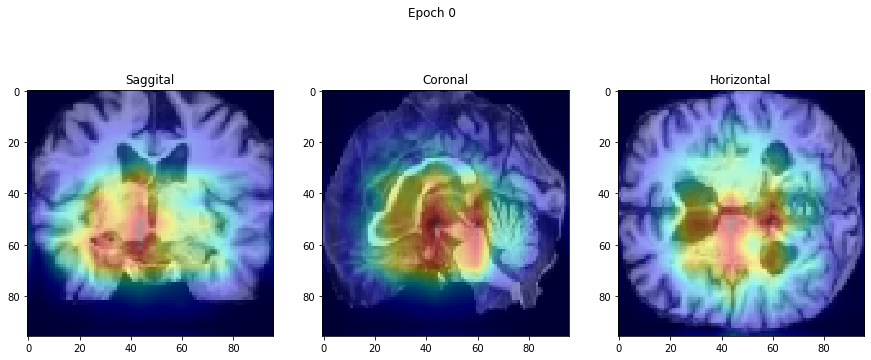

Epoch 5


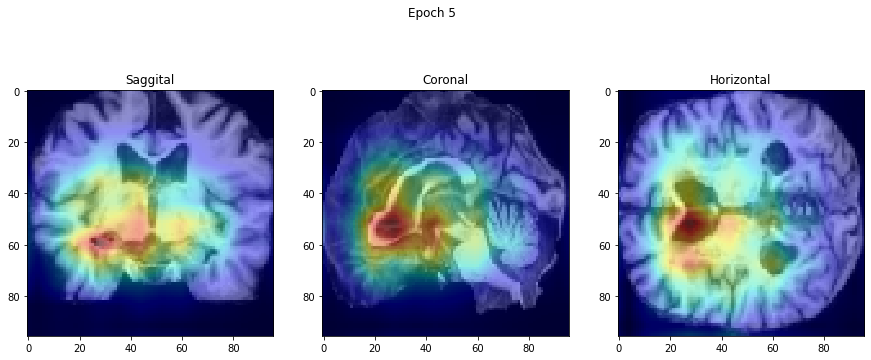

Epoch 8


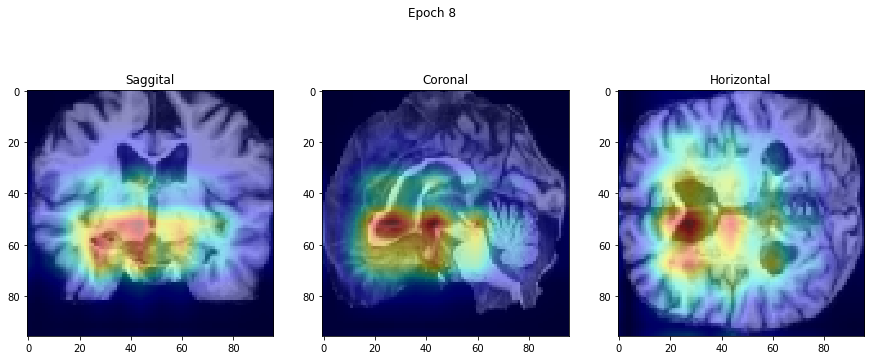

Epoch 10


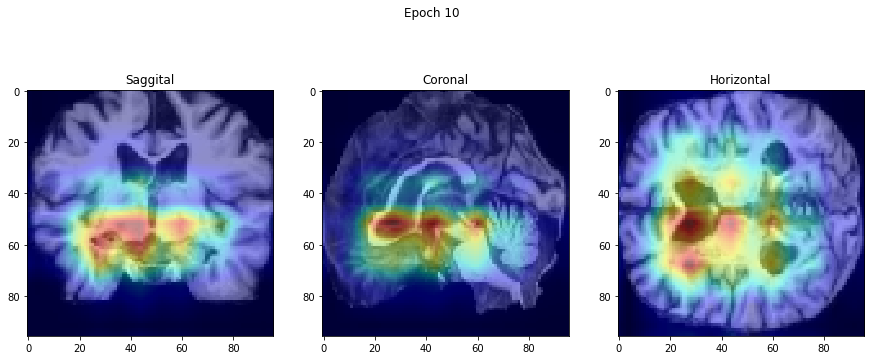

Epoch 15


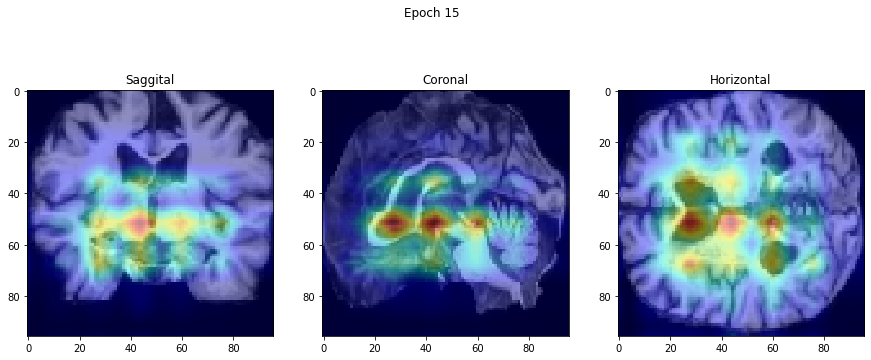

Epoch 20


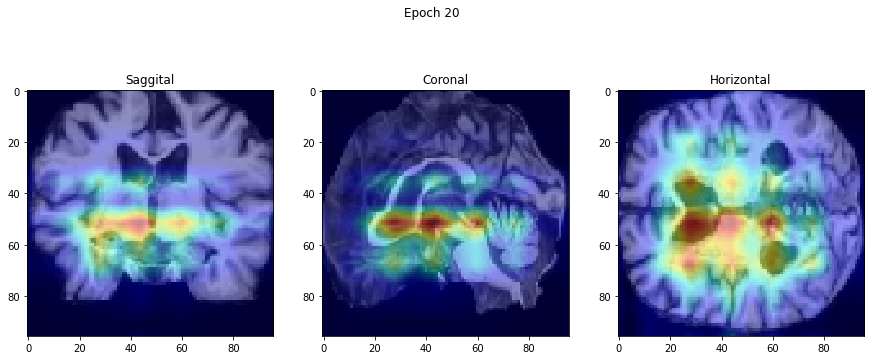

Epoch 21


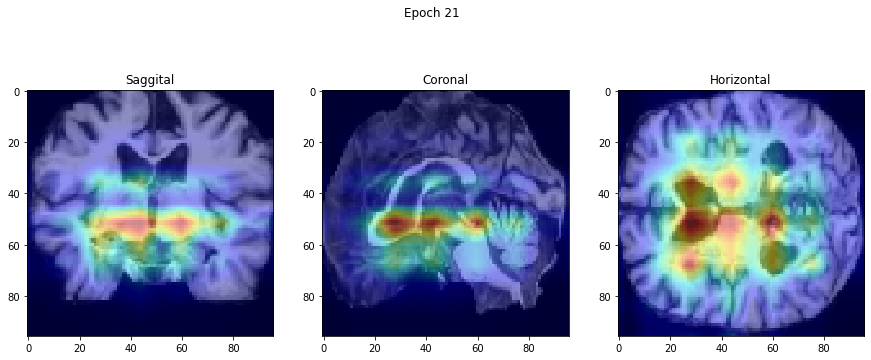

Epoch 24


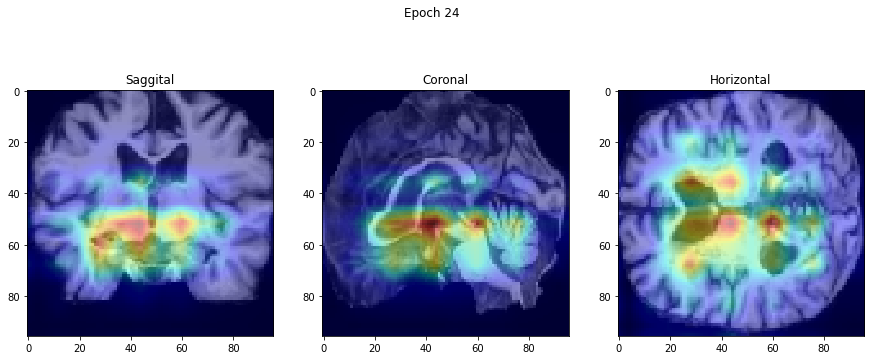

Epoch 25


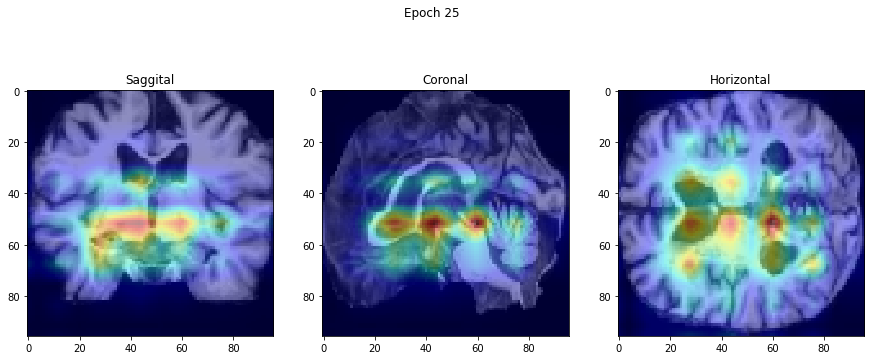

Epoch 30


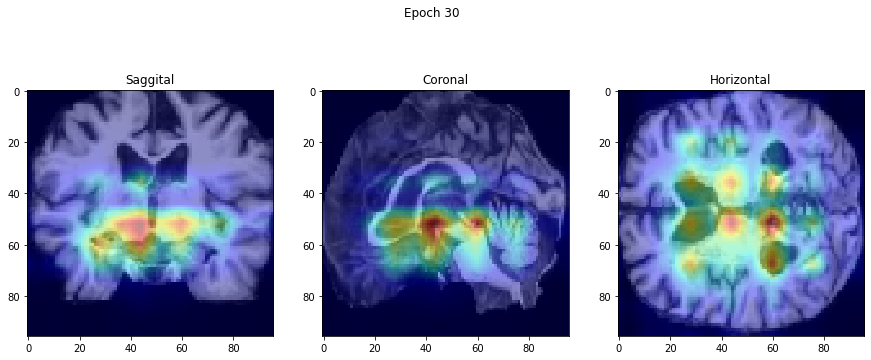

Epoch 35


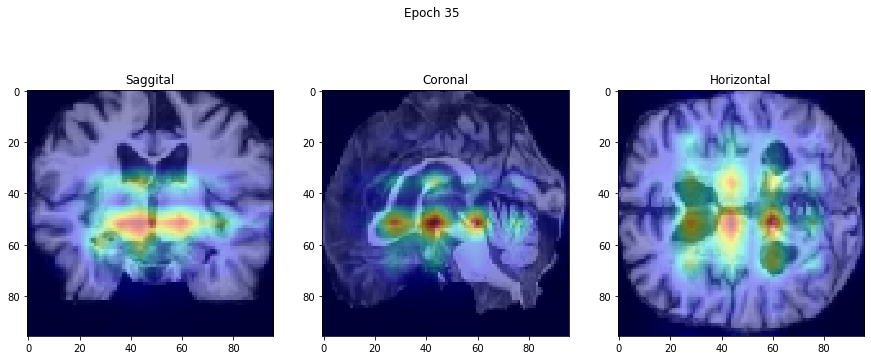

Epoch 40


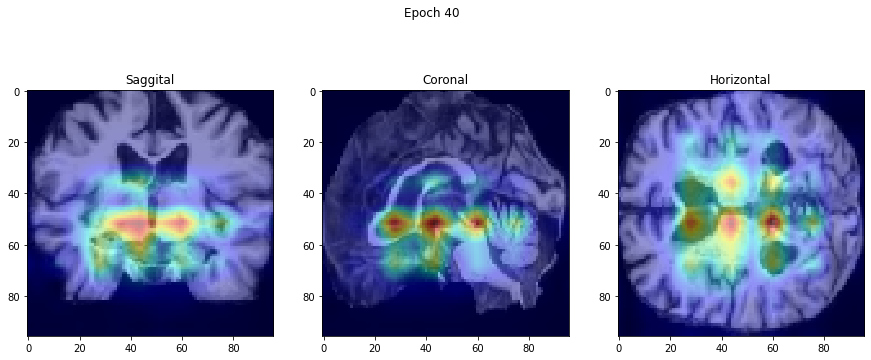

Epoch 45


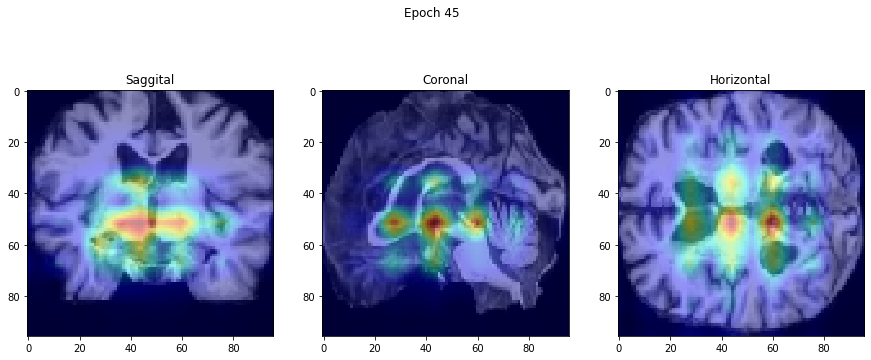

Epoch 50


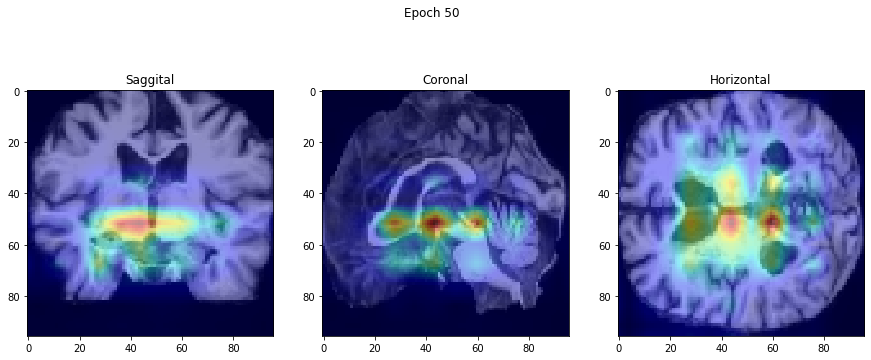

Epoch 51


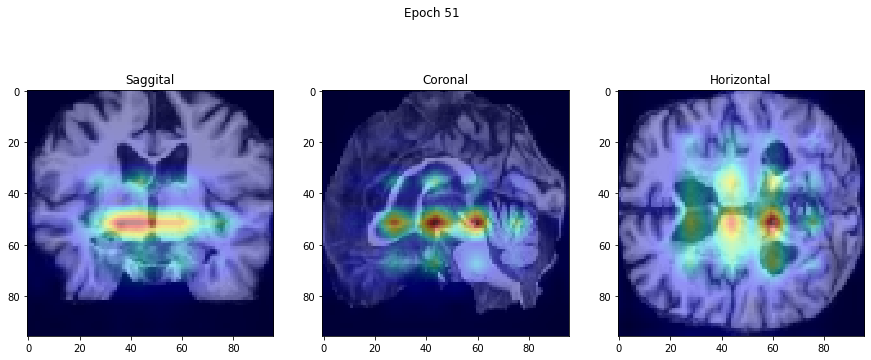

Epoch 55


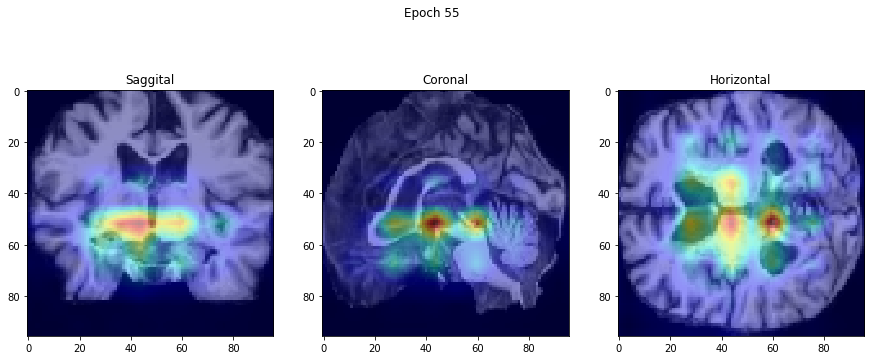

Epoch 60


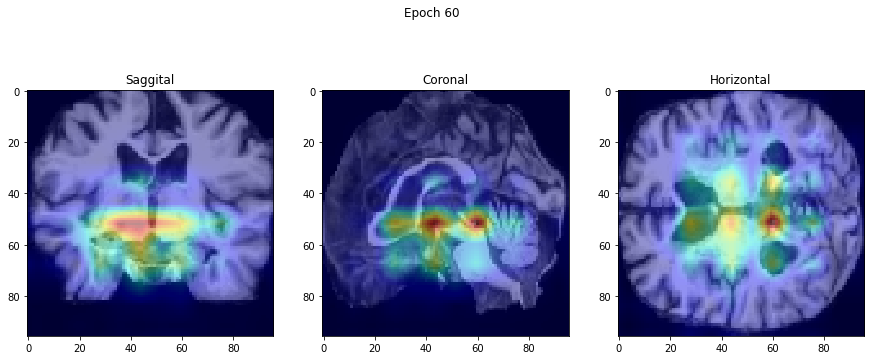

Epoch 65


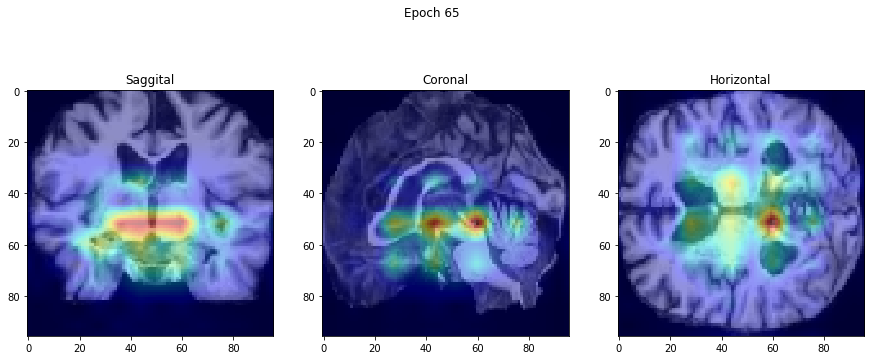

Epoch 70


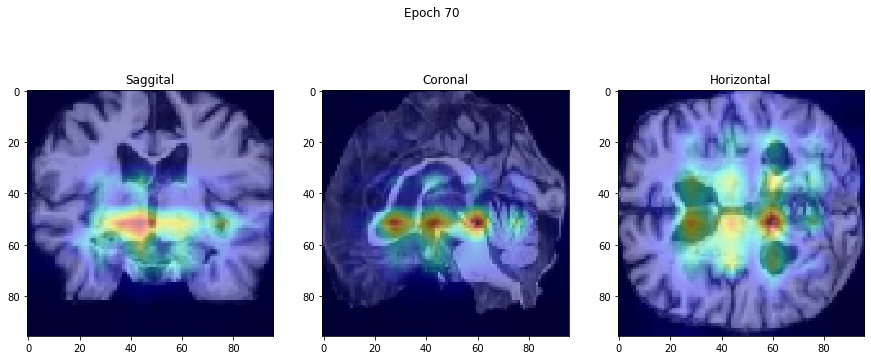

Epoch 75


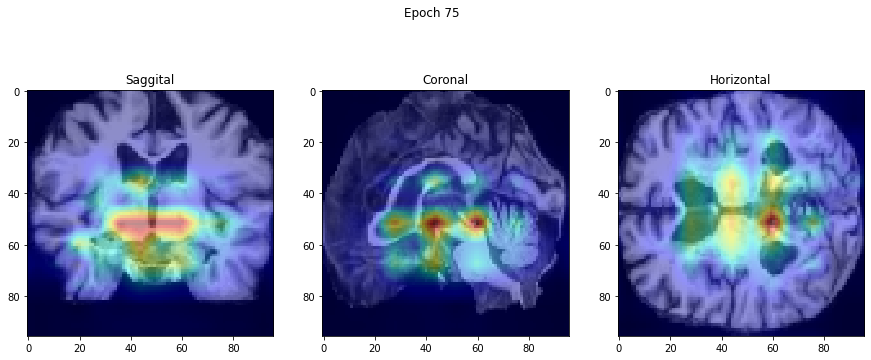

Epoch 80


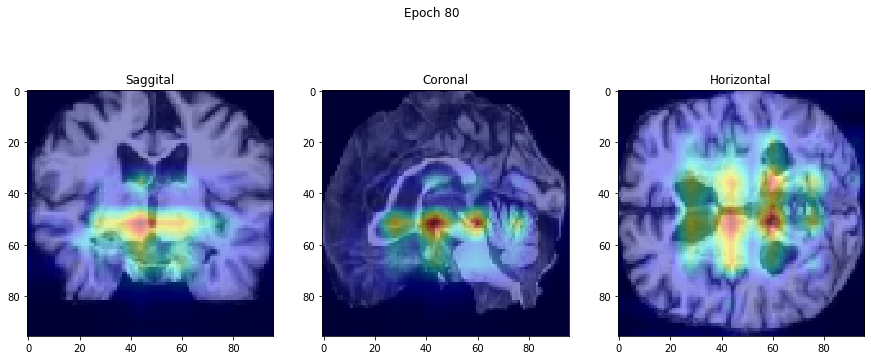

Epoch 85


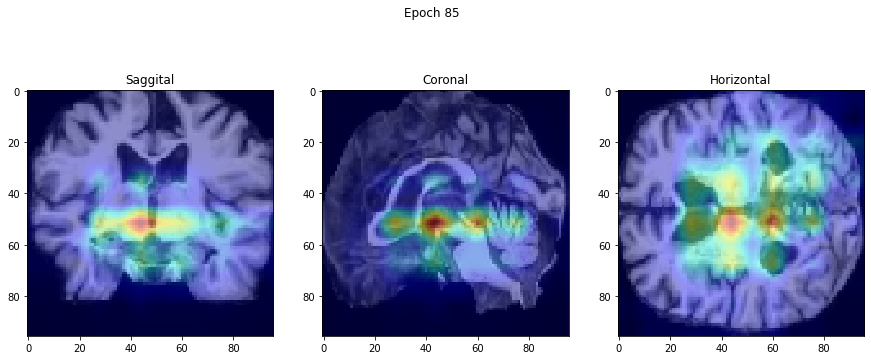

Epoch 90


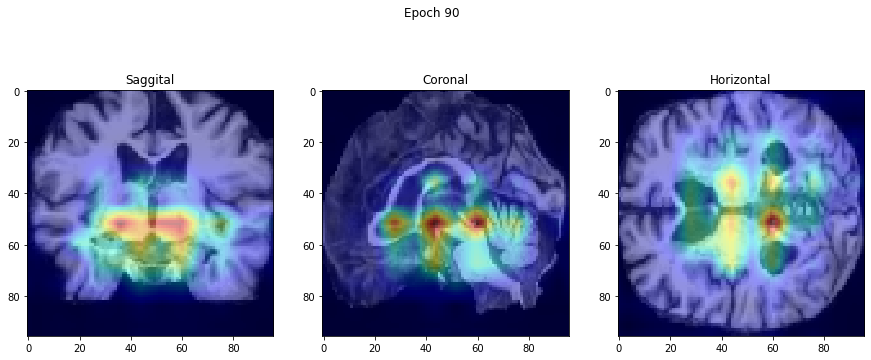

Epoch 95


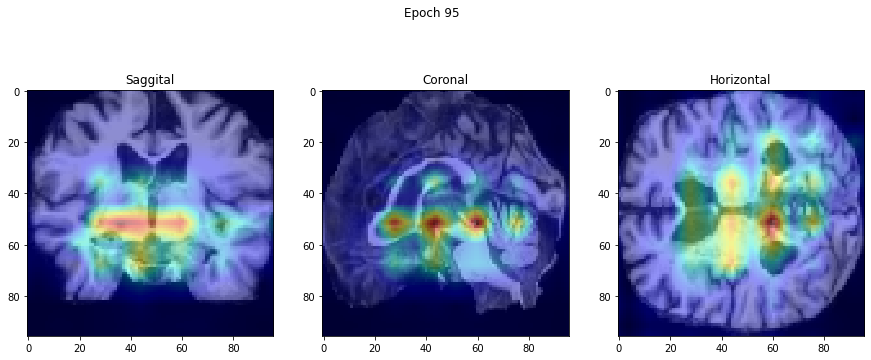

Epoch 95


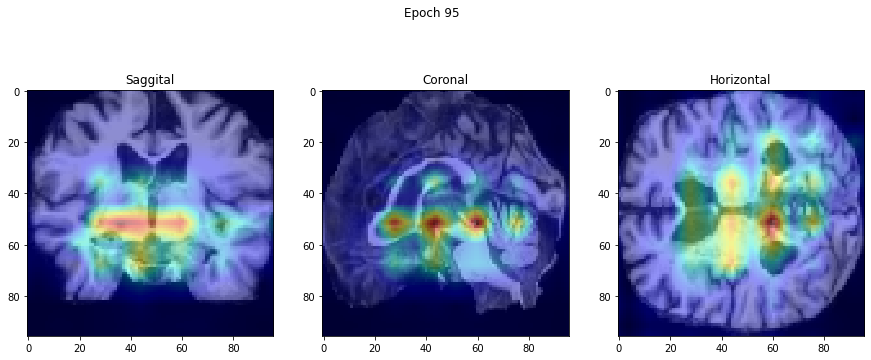

In [2]:
# For Rotated Train
cfg = load_config()
cfg.rot90 = True
cfg.refresh()

cfg.model_name = 'vanilla_residual'
cfg.layers = [8, 16, 32, 64]; cfg.refresh()

camsual = Camsual(cfg, path='2021_03_23_1835_vanilla_residual')
camsual.visualize(4)

Model Vanilla_residual is selected.
Epoch 11


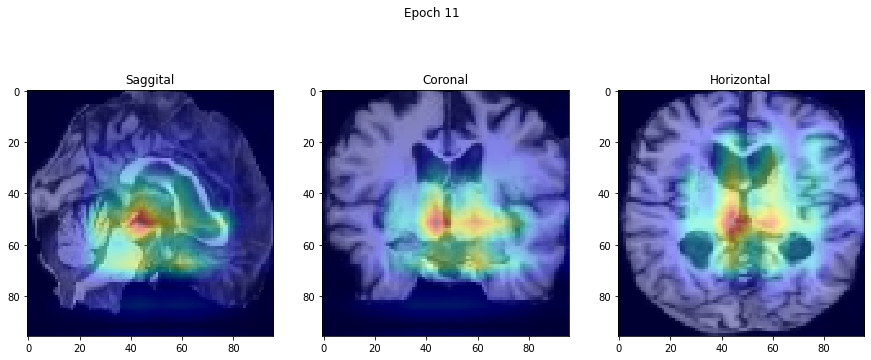

Epoch 20


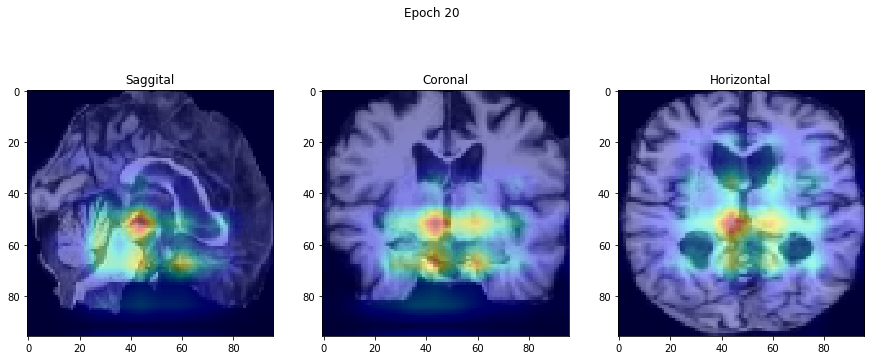

Epoch 23


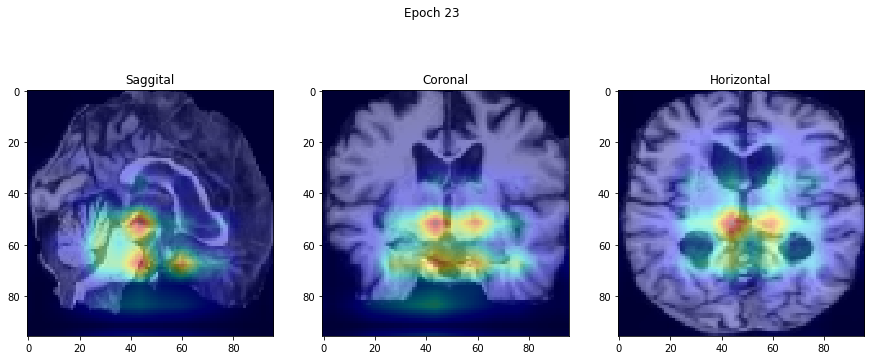

Epoch 30


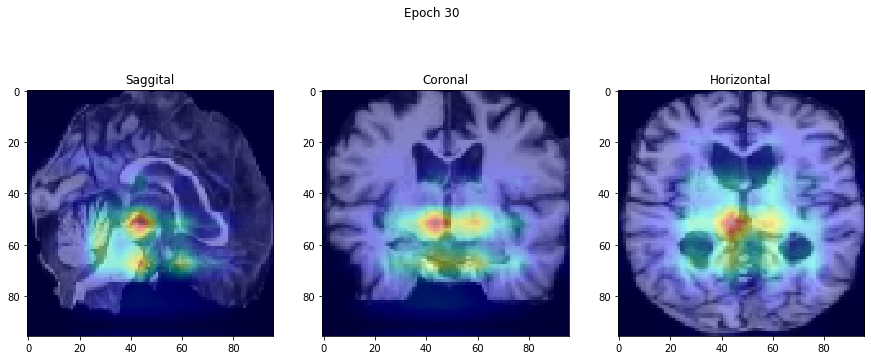

Epoch 33


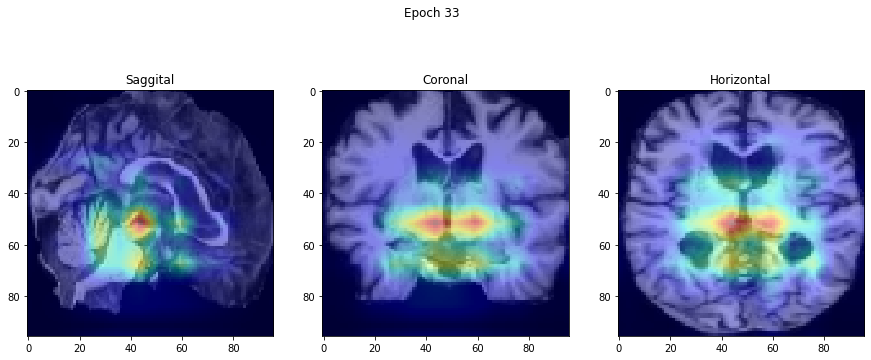

Epoch 34


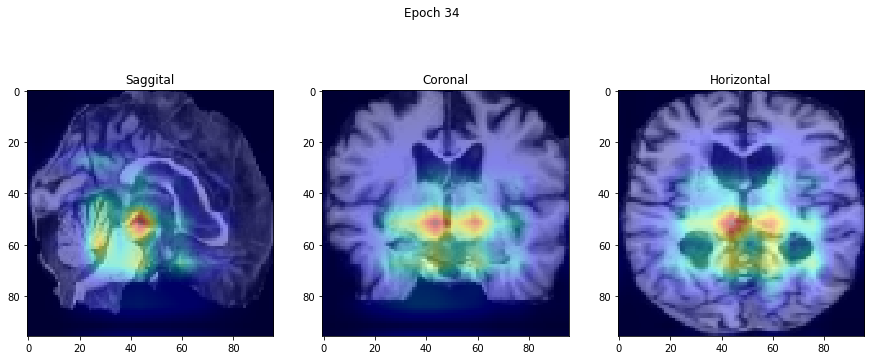

Epoch 37


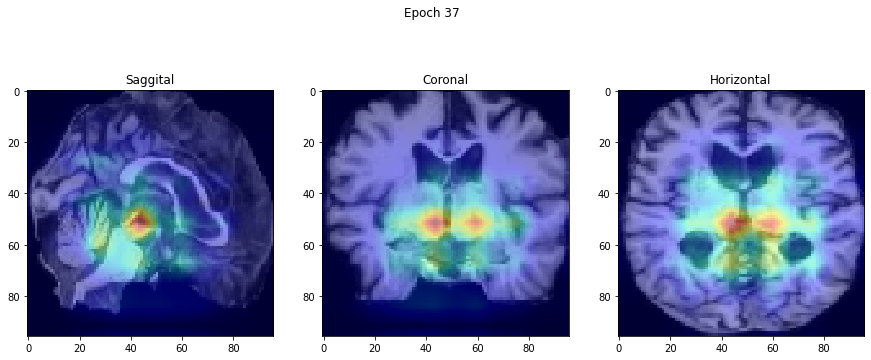

Epoch 47


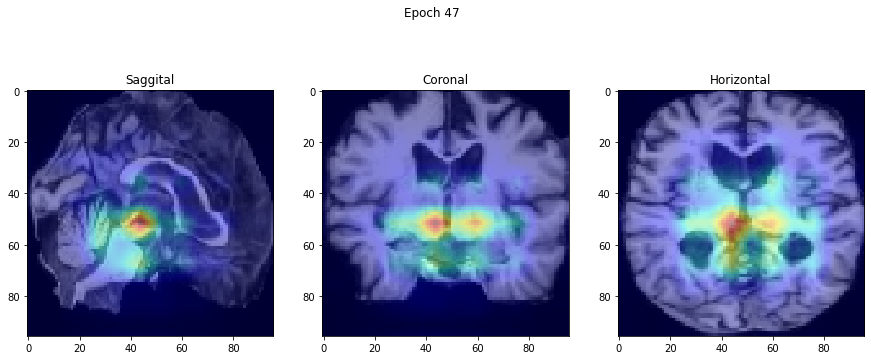

Epoch 51


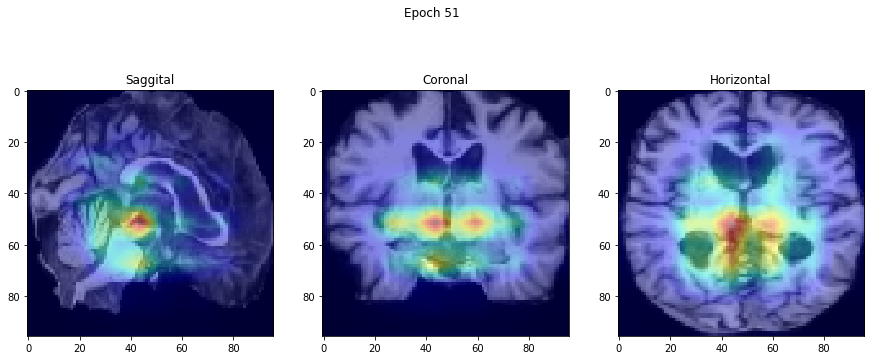

Epoch 57


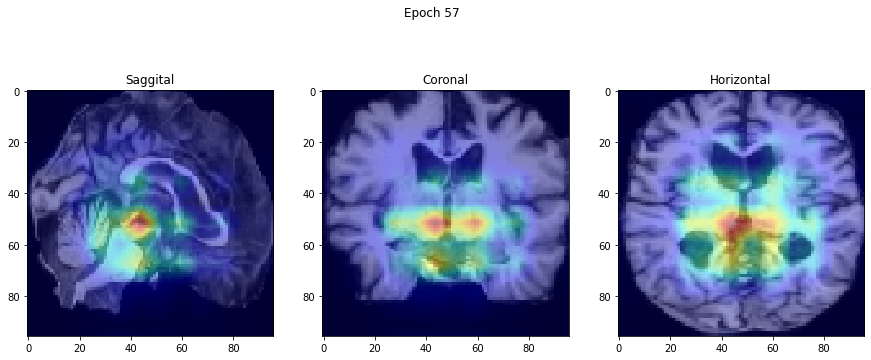

Epoch 92


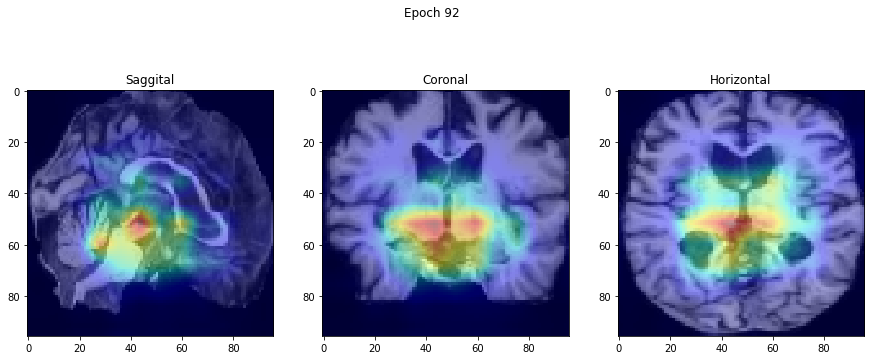

Epoch 94


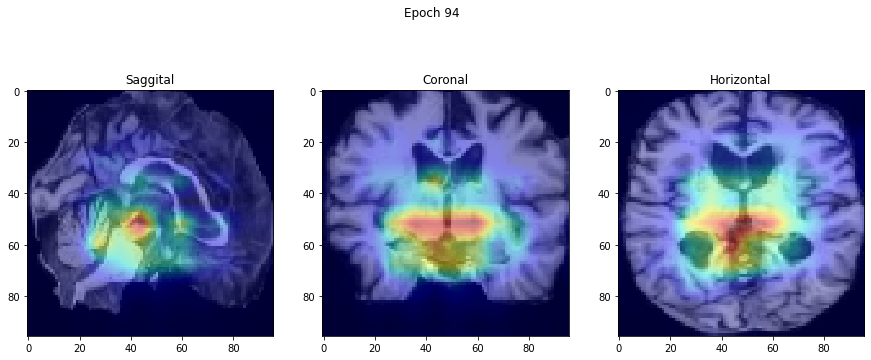

In [3]:
# Non-rotated Train
cfg = load_config()

cfg.model_name = 'vanilla_residual'
cfg.layers = [8, 16, 32, 64]; cfg.refresh()

camsual = Camsual(cfg, path='2021_03_20_1858')
camsual.visualize(4)

In [5]:
from src.visualization.cams import CAM
from src.data.data_util import DatasetPlus
from src.config import *
cfg = load_config()
cfg.rot90 = True
cfg.refresh()
train_dataset = DatasetPlus(cfg, augment=False)
sample_dl = DataLoader(train_dataset, batch_size=1)
iterator = iter(sample_dl)

cfg.model_name = 'vanilla_residual'
cfg.layers = [8, 16, 32, 64]; cfg.refresh()
model, device = load_model(cfg.model_name, verbose=False, cfg=cfg)
# model.load_state_dict(torch.load('./result/models/2021_03_02_1509/best_resnet_ep31-100_sd42_mae6.811.pth'))

Model Vanilla_residual is selected.


In [6]:
from glob import glob
saved_models = sorted(glob('./result/models/2021_03_23_1835_vanilla_residual//*.pth'),
                      key=lambda x: int(x.split('ep')[1].split('-')[0]))
saved_models

['./result/models/2021_03_23_1835_vanilla_residual\\vanilla_residual_ep0-100_sd42_mae8.000.pth',
 './result/models/2021_03_23_1835_vanilla_residual\\vanilla_residual_ep5-100_sd42_mae8.000.pth',
 './result/models/2021_03_23_1835_vanilla_residual\\best_vanilla_residual_ep8-100_sd42_mae7.048.pth',
 './result/models/2021_03_23_1835_vanilla_residual\\vanilla_residual_ep10-100_sd42_mae7.048.pth',
 './result/models/2021_03_23_1835_vanilla_residual\\vanilla_residual_ep15-100_sd42_mae7.048.pth',
 './result/models/2021_03_23_1835_vanilla_residual\\vanilla_residual_ep20-100_sd42_mae7.048.pth',
 './result/models/2021_03_23_1835_vanilla_residual\\best_vanilla_residual_ep21-100_sd42_mae6.960.pth',
 './result/models/2021_03_23_1835_vanilla_residual\\best_vanilla_residual_ep24-100_sd42_mae6.575.pth',
 './result/models/2021_03_23_1835_vanilla_residual\\vanilla_residual_ep25-100_sd42_mae6.575.pth',
 './result/models/2021_03_23_1835_vanilla_residual\\vanilla_residual_ep30-100_sd42_mae6.575.pth',
 './resu

In [7]:
def parser(state):
    
    date, pth_name = state.split('/')[-1].split('\\')
    model_name = pth_name.split('_ep')[0]
    epoch = pth_name.split('_ep')[-1].split('-')[0]
    
    return date, epoch

Epoch 0


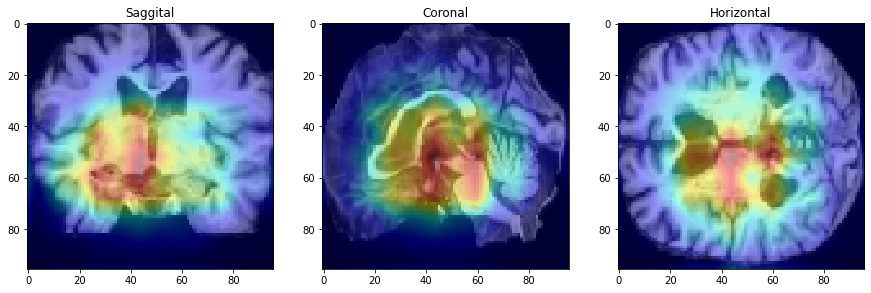

Epoch 5


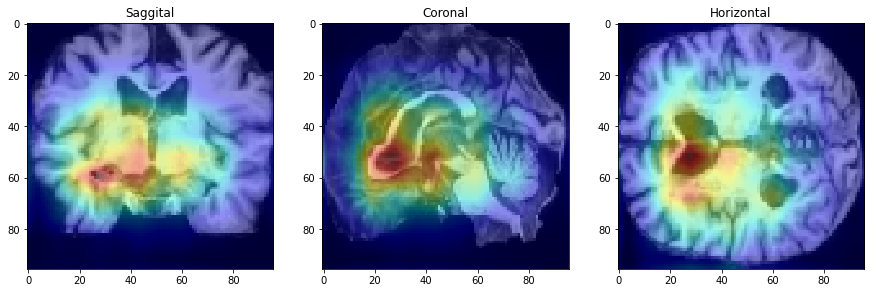

Epoch 8


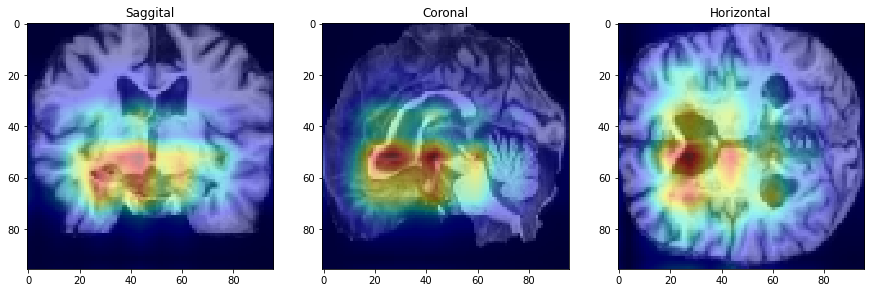

Epoch 10


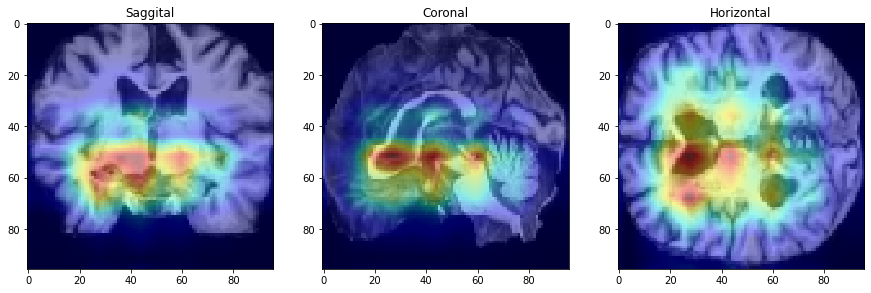

Epoch 15


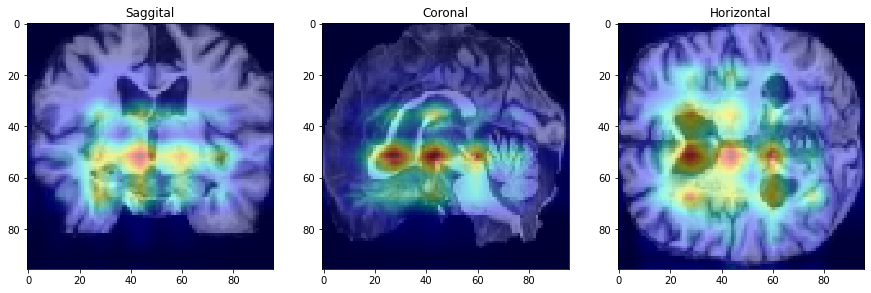

Epoch 20


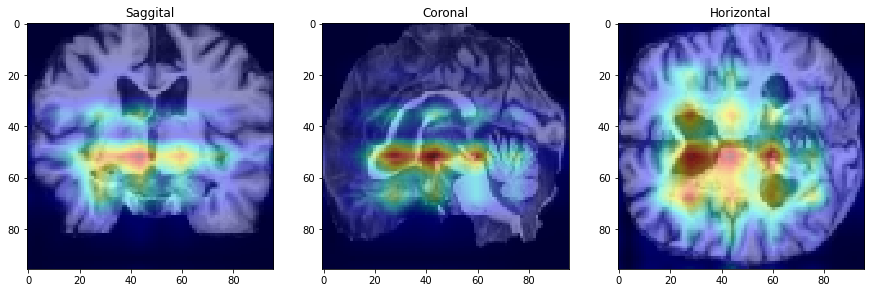

Epoch 21


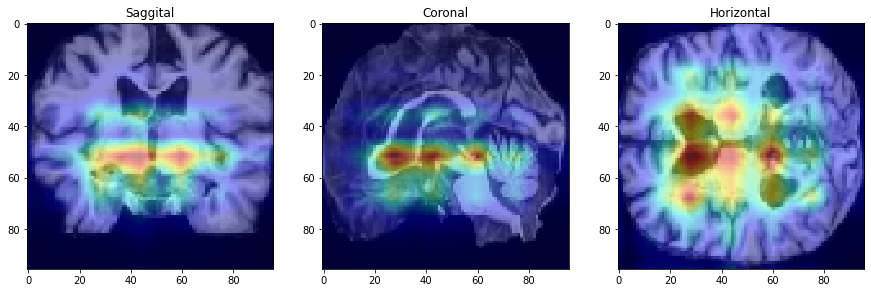

Epoch 24


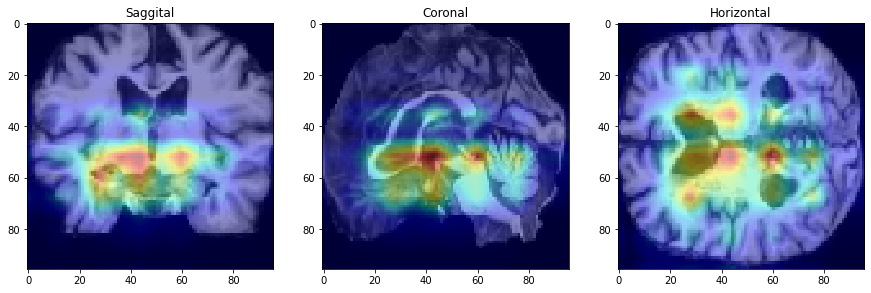

Epoch 25


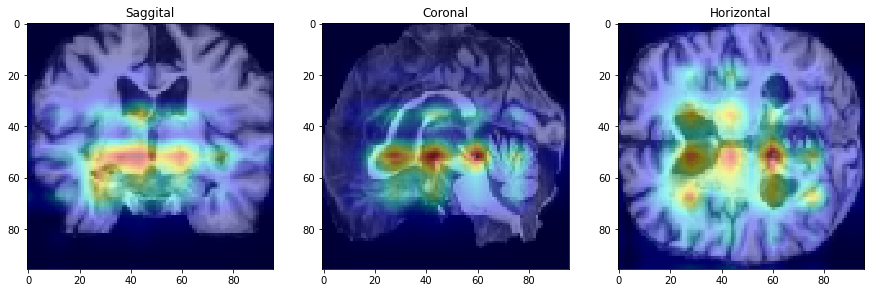

Epoch 30


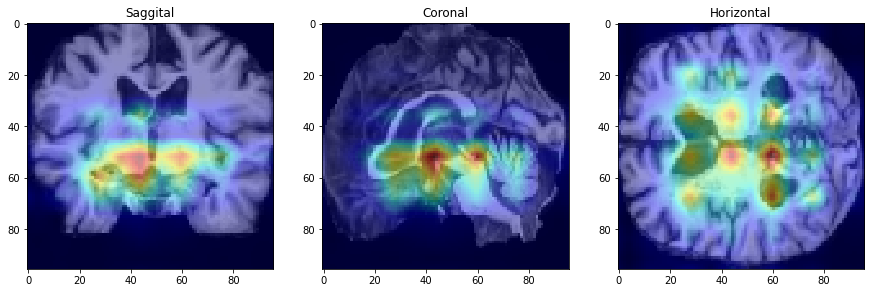

Epoch 35


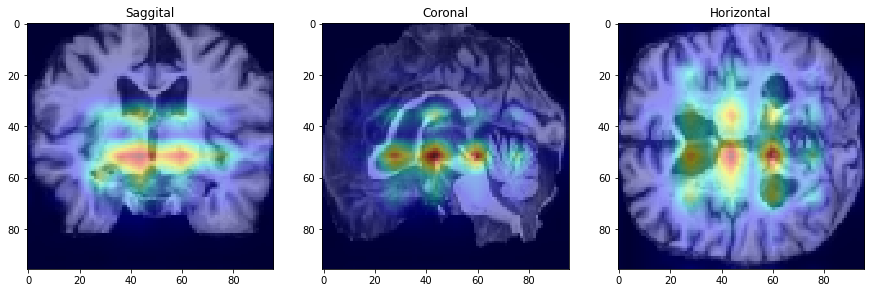

Epoch 40


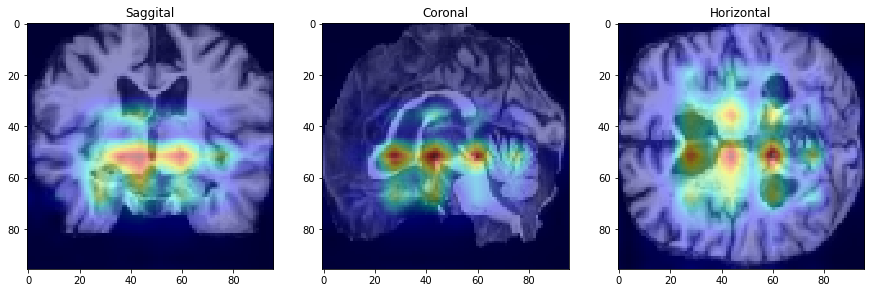

Epoch 45


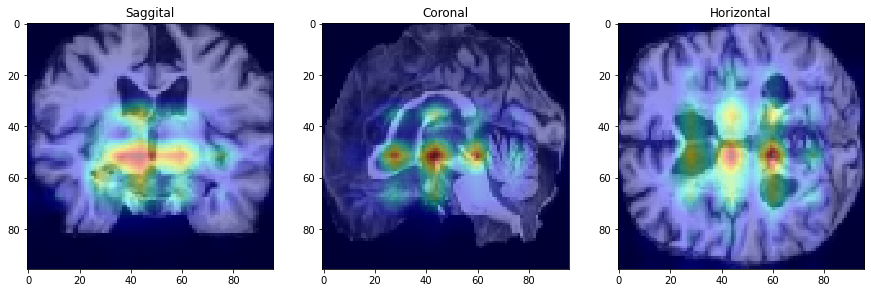

Epoch 50


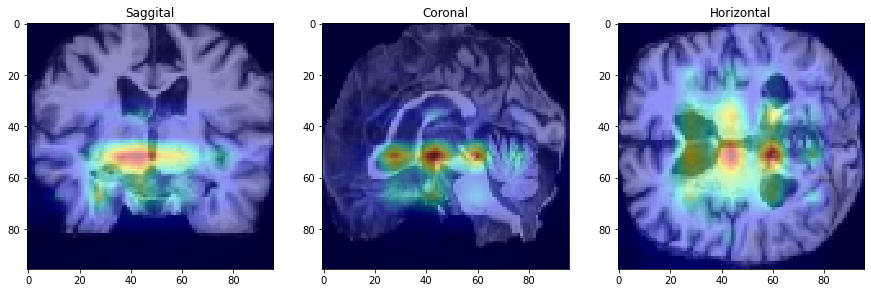

Epoch 51


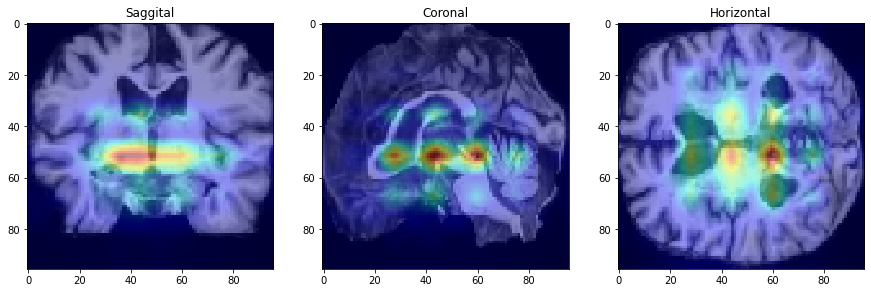

Epoch 55


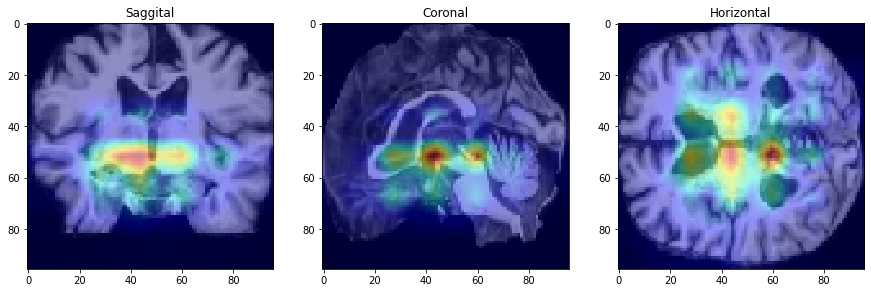

Epoch 60


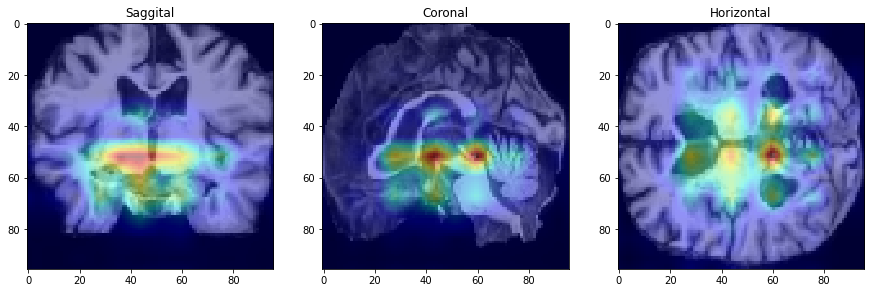

Epoch 65


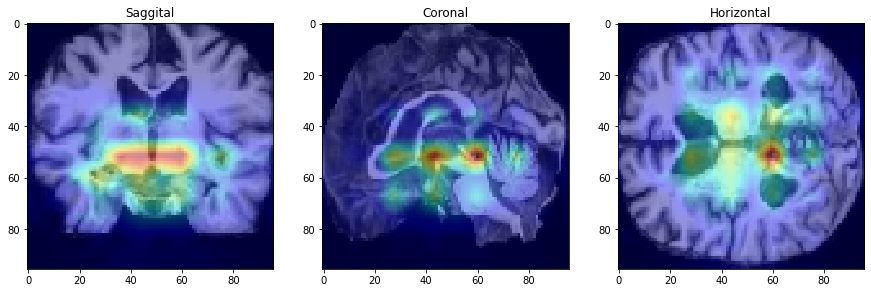

Epoch 70


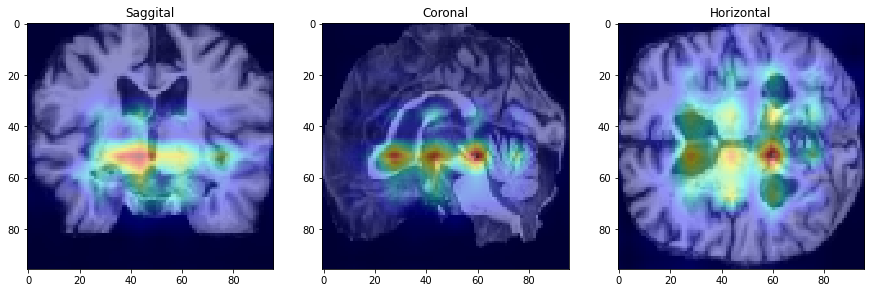

Epoch 75


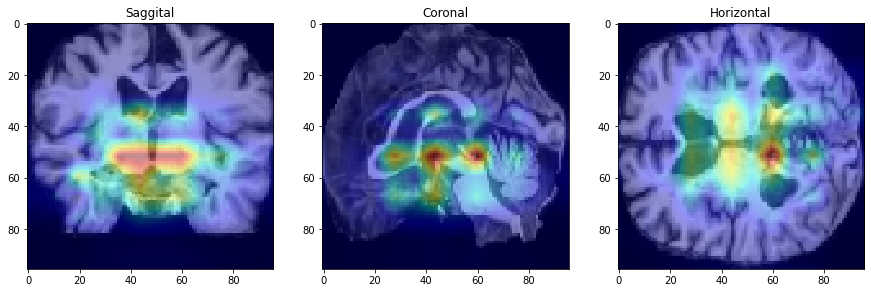

Epoch 80


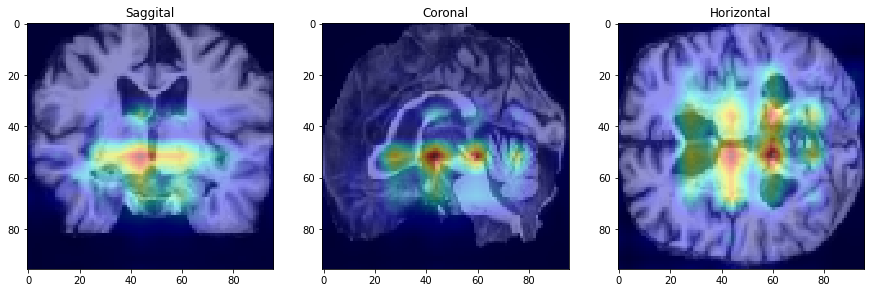

Epoch 85


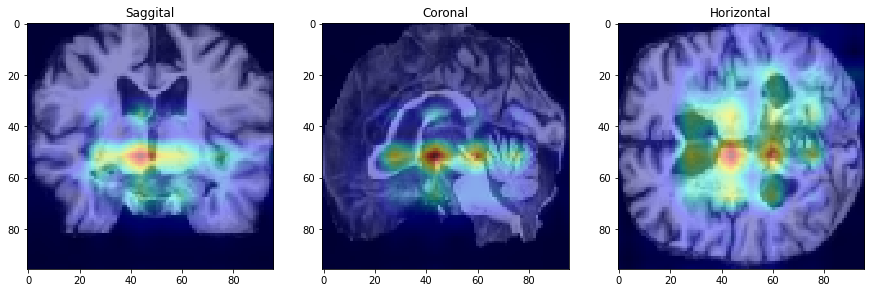

Epoch 90


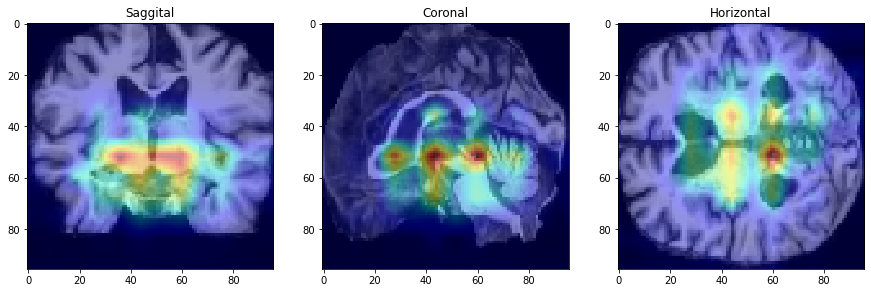

Epoch 95


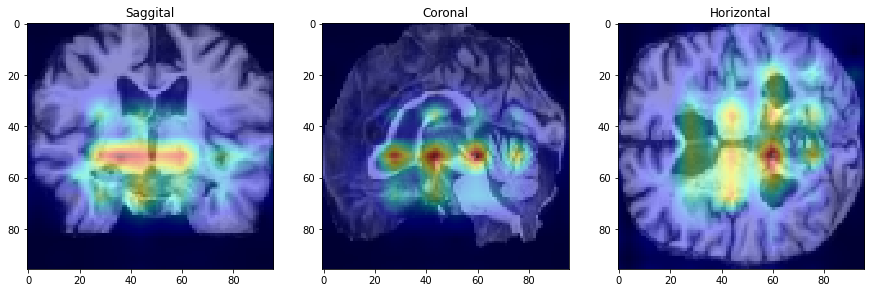

Epoch 95


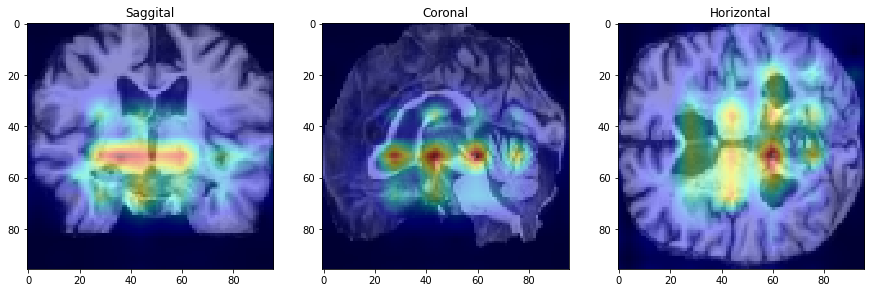

In [8]:
import imageio

data = next(iter(sample_dl))
layer_idx = 4 # range from 0 to 15
for idx, state in enumerate(saved_models):
    
    _, epoch = parser(state)
    print(f'Epoch {epoch}')
    model.load_state_dict(torch.load(state))
    resized_cam = run_gradcam(model, data, cfg)[layer_idx]
    plot_vismap(data[0][0][0], resized_cam, alpha=.4, masked=False, save=True, idx=idx)

In [28]:
with imageio.get_writer('./result/att_tmp_plots/mygif.gif', mode='I') as writer:
    for files in sorted(glob('./result/att_tmp_plots/*.png')):
        image = imageio.imread(files)
        writer.append_data(image)

# Saving Heatmaps

In [36]:
import nibabel as nib

In [13]:
path = train_dataset.data_files[0]
path

'../../brainmask_tlrc/PAL318_mpr_wave1_orig-brainmask_tlrc.npy'

In [69]:
def brain_parser(path, full_path=True):
    
    root = '/'.join(path.split('/')[:2])+'/brainmask_nii/'
    fname = path.split('/')[-1].split('_tlrc')[0]+'.nii'
    return root + fname if full_path else root, fname.split('.nii')[0]

In [75]:
def convert2nifti(path, data, vismap):
    '''
    path: path of original dataloaders', e.g. '../../brainmask_tlrc/PAL318_mpr_wave1_orig-brainmask_tlrc.npy'
    data: a single brain of 5-dim torch.tensor. Will be converted to numpy automatically
    vismap: attention map derived from any methods of - GradCAM, GBP, GuidedGCAM
    
    Does not return anything but instead saved 2 nifti files (registrated brain, visualization map) in
    ../../attmap_result_pairs/filename/*.nii.gz 
    '''
    
    ROOT = '../../attmap_result_pairs/'
    fname = brain_parser(path, full_path=False)[1]
    
    if not os.path.exists(f'{ROOT}{fname}'):
        os.mkdir(f'{ROOT}{fname}')
    
    try:
        # Make Affine
        affine = nib.load(brain_parser(path)).affine

        # Save vismap as nifti
        vismap_nifti = nib.Nifti1Image(vismap, affine)
        nib.save(grad_cam, f'{ROOT}{fname}/{fname}_attmap.nii.gz')

        # Save .npy brain as nifti
        brain = nib.Nifti1Image(data[0][0][0].numpy(), affine)
        nib.save(brain, f'{ROOT}{fname}/{fname}_brain.nii.gz')
        print('Saved')
    
    except:
        print('Error occurred')